#Importing Necessary Libraries

In [2]:
# Installing the libraries with the specified version.
!pip install numpy==1.25.2 pandas==1.5.3 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 sklearn-pandas==2.2.0 -q --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 51.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [3]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
from sklearn.linear_model import LinearRegression

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

##Loading the Dataset

In [4]:
data = pd.read_csv('AirBNB-1.csv')

##Data Overview

In [5]:
data.shape

(74111, 11)

In [6]:
data.head()

,id,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,instant_bookable,review_scores_rating,bedrooms,beds,log_price
0,6901257,Entire home/apt,3.0,1.0,strict,True,f,100.0,1.0,1.0,5.010635
1,6304928,Entire home/apt,7.0,1.0,strict,True,t,93.0,3.0,3.0,5.129899
2,7919400,Entire home/apt,5.0,1.0,moderate,True,t,92.0,1.0,3.0,4.976734
3,13418779,Entire home/apt,4.0,1.0,flexible,True,f,NaN,2.0,2.0,6.620073
4,3808709,Entire home/apt,2.0,1.0,moderate,True,t,40.0,0.0,1.0,4.744932


##Distribution of Categorical Variables

In [7]:
print(data['room_type'].value_counts())

room_type
Entire home/apt    41308
Private room       30635
Shared room         2163
Name: count, dtype: int64


In [8]:
print(data['cancellation_policy'].value_counts())

cancellation_policy
strict      32500
flexible    22543
moderate    19060
Name: count, dtype: int64


In [9]:
print(data['cleaning_fee'].value_counts())

cleaning_fee
True     54399
False    19708
Name: count, dtype: int64


In [10]:
print(data['instant_bookable'].value_counts())

instant_bookable
f    54660
t    19451
Name: count, dtype: int64


In [11]:
#Are there any missing values?
print('There are ', data.isnull().sum().sum(), 'missing values across all columns in the data')

There are  17168 missing values across all columns in the data


In [12]:
#Which columns have missing columns?
data.isnull().sum()

id                          0
room_type                   5
accommodates                3
bathrooms                 203
cancellation_policy         8
cleaning_fee                4
instant_bookable            0
review_scores_rating    16722
bedrooms                   92
beds                      131
log_price                   0
dtype: int64

In [13]:
data['id'].nunique() #remove this variable due to it providing no statistical information because it is an identification variable.

74111

In [14]:
#Dropping ID variable
data = data.drop('id', axis = 1)

##Exploratory Data Analysis (EDA)

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,74108.0,3.155125,2.153603,1.0,2.000000,2.00000,4.000000,16.000000
bathrooms,73908.0,1.235272,0.582054,0.0,1.000000,1.00000,1.000000,8.000000
review_scores_rating,57389.0,94.067365,7.836556,20.0,92.000000,96.00000,100.000000,100.000000
bedrooms,74019.0,1.265797,0.852149,0.0,1.000000,1.00000,1.000000,10.000000
beds,73980.0,1.710868,1.254142,0.0,1.000000,1.00000,2.000000,18.000000
log_price,74111.0,4.782069,0.717394,0.0,4.317488,4.70953,5.220356,7.600402


In [16]:
#User defined function for batch univariate data analysis of quantitative features in a dataset
def univariate_analysis(data, feature, include_def = False):
  """
  This function computes major and minor outliers
  as defined in 'Introduction to Contemporary Statistical Methods --  second edition' by Dr. Lambert H. Koopmans (pg. 53).
  Minor outliers are defined by those values which are beyond Q3/Q1 +/- 1.5*IQR but less than Q3/Q1 +/- 3*IQR
  Major/Extreme outliers are defined by those values which are beyond Q3/Q1 +/- 3*IQR
  Also, this function computes other relevant statistics and plots germane to a univariate analysis of a random variable.

  Please note the following definitions/descriptions of skewness and kurtosis from the Engineering Statistics Handbook (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm):
  *Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.
  **Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers.
  **Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.
  """
  import pandas as pd
  import numpy as np
  import math

  import matplotlib.pyplot as plt
  import seaborn as sns
  from scipy.stats import skew
  from scipy.stats import kurtosis
  ##Display Plots
  fig, axes = plt.subplots(ncols = 3, figsize = (15,5))
  sns.boxplot(data = data, x = feature, ax = axes[0]).set(title = f'Boxplot of {feature}')
  sns.histplot(data = data, x = feature, ax = axes[1]).set(title = f'Histogram plot of {feature}')
  sns.kdeplot(data = data, x = feature, ax = axes[2]).set(title = f'Density plot of {feature}')
  plt.show()

  Q1 = data[feature].quantile(.25) ; Q3 = data[feature].quantile(.75) ; Q2 = data[feature].quantile(.5) ; Mean = data[feature].mean()
  STD = np.std(data[feature]); SNR = Mean/STD ; CV = STD/Mean ; Skew = skew(data[feature], nan_policy = 'omit') ; Kurtosis = kurtosis(data[feature], nan_policy = 'omit')
  IQR = Q3 - Q1
  upper_fence = Q3 + 1.5*IQR ; lower_fence = Q1 - 1.5*IQR
  outer_upper_fence = Q3 + 3*IQR ; outer_lower_fence = Q1 - 3*IQR
  minor_outliers_Q3 = []
  major_outliers_Q3 = []
  minor_outliers_Q1 = []
  major_outliers_Q1 = []
  for i in range(data[(data[feature]>upper_fence) & (data[feature]<=outer_upper_fence)].shape[0]):
    minor_outliers_Q3.append(data[(data[feature]>upper_fence) & (data[feature]<=outer_upper_fence)].loc[:,feature].values[i])
  if len(minor_outliers_Q3) == 0:
    print('*There are no minor outliers beyond Quartile-3 + 1.5*IQR!')
  else:
    print('*The number of minor outliers beyond Quartile-3 + 1.5*IQR are:', len(minor_outliers_Q3), 'and the average of these outliers are:', round(pd.Series(minor_outliers_Q3).mean(), ndigits=2))
  for i in range(data[data[feature]> outer_upper_fence].shape[0]):
    major_outliers_Q3.append(data[data[feature]> outer_upper_fence].loc[:,feature].values[i])
  if len(major_outliers_Q3) == 0:
    print('*There are no major outliers beyond Quartile-3 + 3*IQR!')
  else:
    print('*The number major outliers beyond Quartile-3 + 3*IQR are:', len(major_outliers_Q3), 'and the average of these outliers are:', round(pd.Series(major_outliers_Q3).mean(), ndigits=2))
  for i in range(data[(data[feature]>= outer_lower_fence) & (data[feature]<lower_fence)].shape[0]):
    minor_outliers_Q1.append(data[(data[feature]>= outer_lower_fence) & (data[feature]<lower_fence)].loc[:,feature].values[i])
  if len(minor_outliers_Q1) == 0:
    print('*There are no minor outliers below Quartile-1 - 1.5*IQR!')
  else:
    print('*The number of minor outliers below Quartile-1 - 1.5*IQR are:', len(minor_outliers_Q1), 'and the average of these outliers are:', round(pd.Series(minor_outliers_Q1).mean(), ndigits=2))
  for i in range(data[(data[feature]<outer_lower_fence)].shape[0]):
    major_outliers_Q1.append(data[(data[feature]<outer_lower_fence)].loc[:,feature].values[i])
  if len(major_outliers_Q1) == 0:
    print('*There are no major outliers below Quartile-1 - 3*IQR!')
  else:
    print('*The number major outliers below Quartile-1 - 3*IQR are:', len(major_outliers_Q1), 'and the average of these outliers are:', round(pd.Series(major_outliers_Q1).mean(), ndigits=2))
  print('-'*50)
  print('-'*50)
  print('*Quartile-1 is:', round(Q1, ndigits=2))
  print('*Quartile-2 (median) is:', round(Q2, ndigits = 2))
  print('*Quartile-3 is:', round(Q3, ndigits = 2))
  print('*Quartile-1 - 1.5*IQR = ', round(lower_fence, ndigits = 2))
  print('*Quartile-1 - 3*IQR = ', round(outer_lower_fence, ndigits=2))
  print('*Quartile-3 + 1.5*IQR = ', round(upper_fence, ndigits=2))
  print('*Quartile-3 + 3*IQR = ', round(outer_upper_fence, ndigits=2))
  print('-'*50)
  print('-'*50)
  print(f'*Average of {feature} is:', round(Mean, ndigits=2))
  print(f'*Standard deviation of {feature} is:', round(STD, ndigits=2))
  print(f'*Skewness of {feature} is:', round(Skew, ndigits=2))
  print(f'*Kurtosis of {feature} is:', round(Kurtosis, ndigits = 2))
  print(f'*Coefficient of variation of {feature} is:', round(CV, ndigits = 2))
  if data[feature].min()>=0:
    print(f'*Signal to Noise Ratio of {feature} is:', round(SNR, ndigits=2))
    print('**Note: Signal to Noise Ratio statistic is only applicable to variables which are always non-negative**')
  else:
    print('*Signal to Noise Ratio DOES NOT EXIST')
  print('-'*50)
  print('-'*50)

  if include_def == True:
    print('**Definitions:')
    print(f'*Skewness is a measure of symmetry, or more precisely, the lack of symmetry. \n A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.')

    print(f'*Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. \n That is, data sets with high kurtosis tend to have heavy tails, or outliers. \n Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case.')







In [17]:
numeric_col = []
for i in range(data.shape[1]):
    if data.dtypes[i] == 'int64' or data.dtypes[i] == 'float64':
        numeric_col.append(data.dtypes.index[i])
print(f'The numeric features of the data are: {numeric_col}')


The numeric features of the data are: ['accommodates', 'bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'log_price']


In [18]:
categorical_col = []
for i in range(data.shape[1]):
    if data.dtypes[i] == 'object':
        categorical_col.append(data.dtypes.index[i])
print(f'The categorical features of the data are: {categorical_col}')


The categorical features of the data are: ['room_type', 'cancellation_policy', 'cleaning_fee', 'instant_bookable']


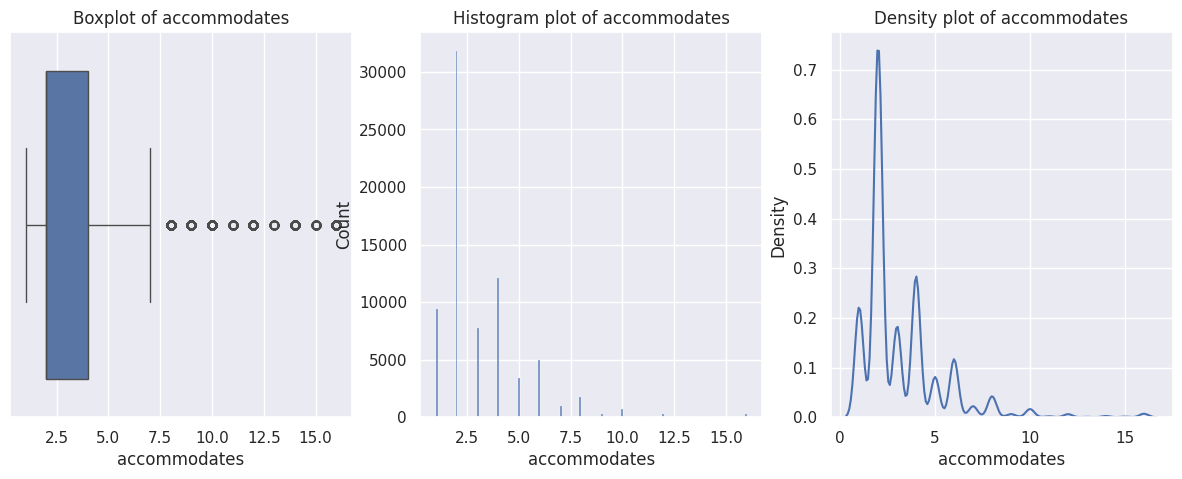

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 2766 and the average of these outliers are: 8.6
*The number major outliers beyond Quartile-3 + 3*IQR are: 838 and the average of these outliers are: 13.83
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 2.0
*Quartile-2 (median) is: 2.0
*Quartile-3 is: 4.0
*Quartile-1 - 1.5*IQR =  -1.0
*Quartile-1 - 3*IQR =  -4.0
*Quartile-3 + 1.5*IQR =  7.0
*Quartile-3 + 3*IQR =  10.0
--------------------------------------------------
--------------------------------------------------
*Average of accommodates is: 3.16
*Standard deviation of accommodates is: 2.15
*Skewness of accommodates is: 2.23
*Kurtosis of accommodates is: 7.43
*Coefficient of variation of accommodates is: 0.68
*Signal to Noise Ratio of accommodates is: 1.47
**Note: Signal to Noise Ratio stat

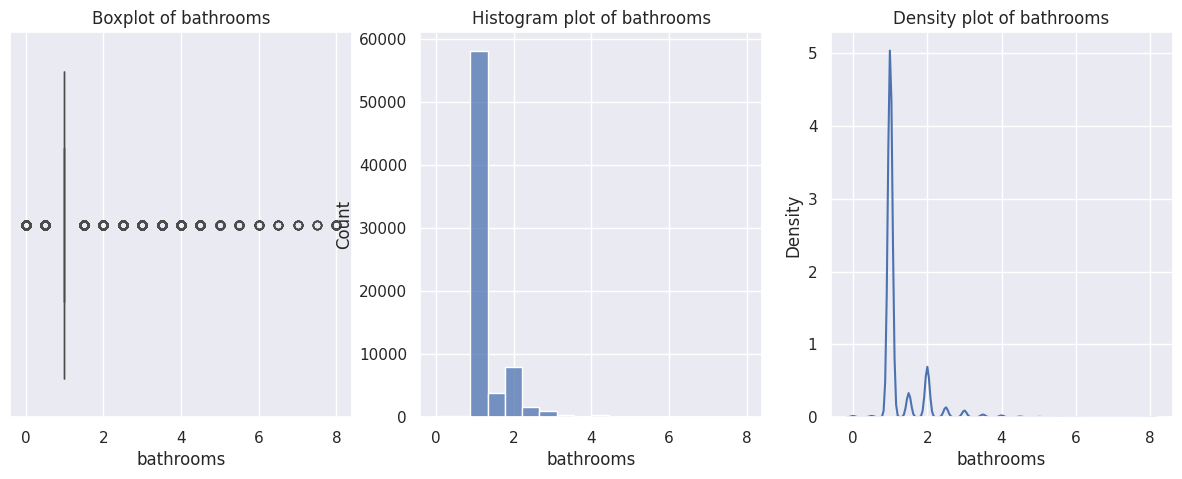

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*The number major outliers beyond Quartile-3 + 3*IQR are: 15405 and the average of these outliers are: 2.15
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*The number major outliers below Quartile-1 - 3*IQR are: 407 and the average of these outliers are: 0.26
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 1.0
*Quartile-1 - 1.5*IQR =  1.0
*Quartile-1 - 3*IQR =  1.0
*Quartile-3 + 1.5*IQR =  1.0
*Quartile-3 + 3*IQR =  1.0
--------------------------------------------------
--------------------------------------------------
*Average of bathrooms is: 1.24
*Standard deviation of bathrooms is: 0.58
*Skewness of bathrooms is: 3.69
*Kurtosis of bathrooms is: 22.23
*Coefficient of variation of bathrooms is: 0.47
*Signal to Noise Ratio of bathrooms is: 2.12
**Note: Signal to Noise Ratio statistic is only applicab

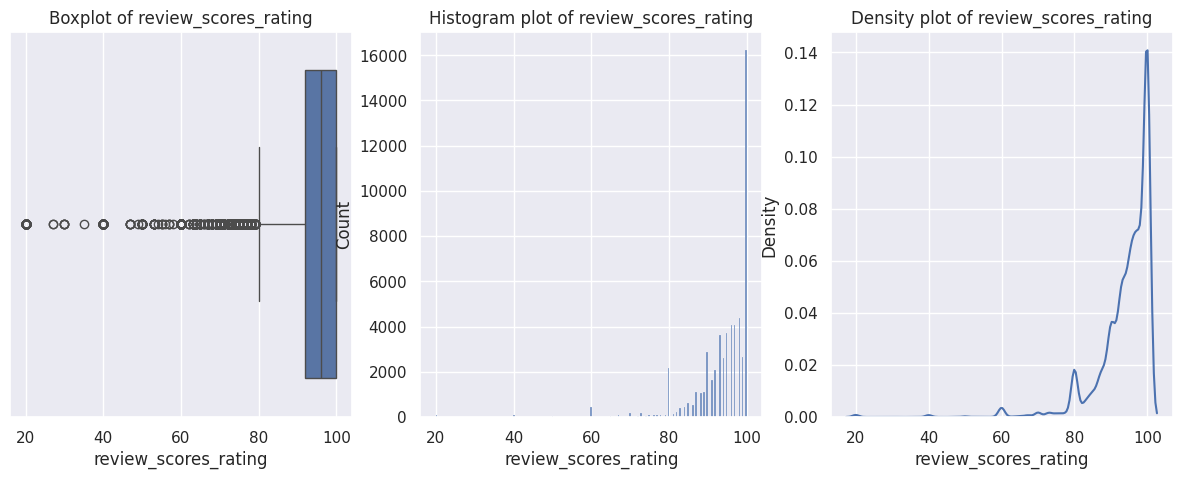

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*The number of minor outliers below Quartile-1 - 1.5*IQR are: 905 and the average of these outliers are: 74.02
*The number major outliers below Quartile-1 - 3*IQR are: 814 and the average of these outliers are: 53.03
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 92.0
*Quartile-2 (median) is: 96.0
*Quartile-3 is: 100.0
*Quartile-1 - 1.5*IQR =  80.0
*Quartile-1 - 3*IQR =  68.0
*Quartile-3 + 1.5*IQR =  112.0
*Quartile-3 + 3*IQR =  124.0
--------------------------------------------------
--------------------------------------------------
*Average of review_scores_rating is: 94.07
*Standard deviation of review_scores_rating is: 7.84
*Skewness of review_scores_rating is: -3.38
*Kurtosis of review_scores_rating is: 20.02
*Coefficient of variation of review_scores_rating is: 0.08
*Signal to Noise Ratio of revie

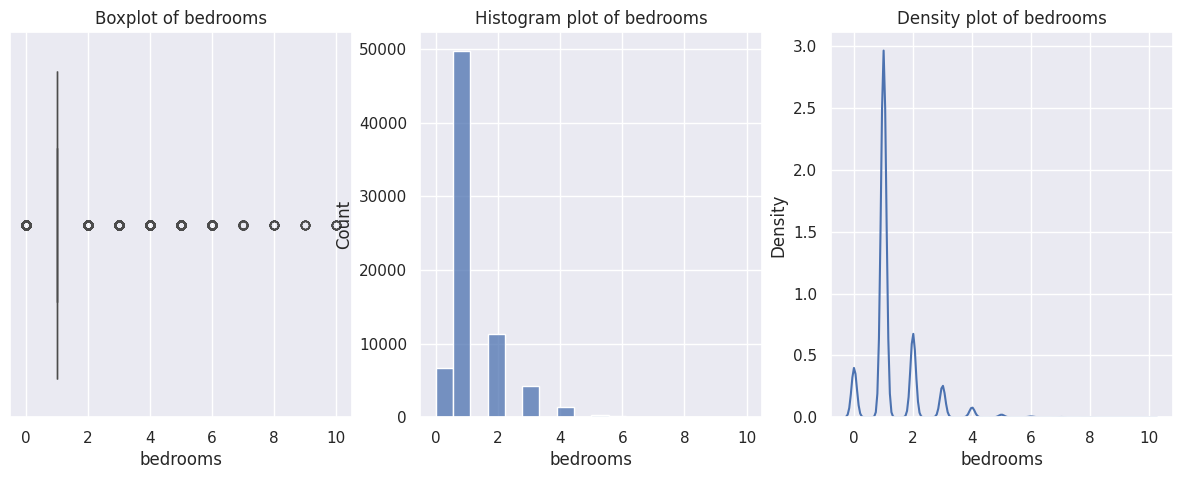

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*The number major outliers beyond Quartile-3 + 3*IQR are: 17521 and the average of these outliers are: 2.51
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*The number major outliers below Quartile-1 - 3*IQR are: 6715 and the average of these outliers are: 0.0
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 1.0
*Quartile-1 - 1.5*IQR =  1.0
*Quartile-1 - 3*IQR =  1.0
*Quartile-3 + 1.5*IQR =  1.0
*Quartile-3 + 3*IQR =  1.0
--------------------------------------------------
--------------------------------------------------
*Average of bedrooms is: 1.27
*Standard deviation of bedrooms is: 0.85
*Skewness of bedrooms is: 1.99
*Kurtosis of bedrooms is: 7.58
*Coefficient of variation of bedrooms is: 0.67
*Signal to Noise Ratio of bedrooms is: 1.49
**Note: Signal to Noise Ratio statistic is only applicable to v

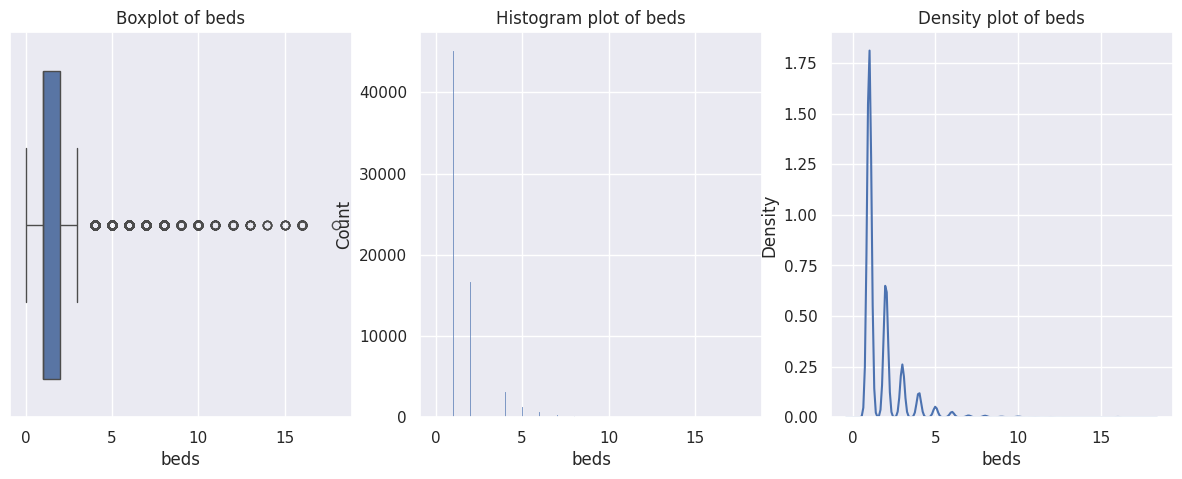

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 4352 and the average of these outliers are: 4.3
*The number major outliers beyond Quartile-3 + 3*IQR are: 1334 and the average of these outliers are: 7.49
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 2.0
*Quartile-1 - 1.5*IQR =  -0.5
*Quartile-1 - 3*IQR =  -2.0
*Quartile-3 + 1.5*IQR =  3.5
*Quartile-3 + 3*IQR =  5.0
--------------------------------------------------
--------------------------------------------------
*Average of beds is: 1.71
*Standard deviation of beds is: 1.25
*Skewness of beds is: 3.36
*Kurtosis of beds is: 19.72
*Coefficient of variation of beds is: 0.73
*Signal to Noise Ratio of beds is: 1.36
**Note: Signal to Noise Ratio statistic is only applicable to variables which are 

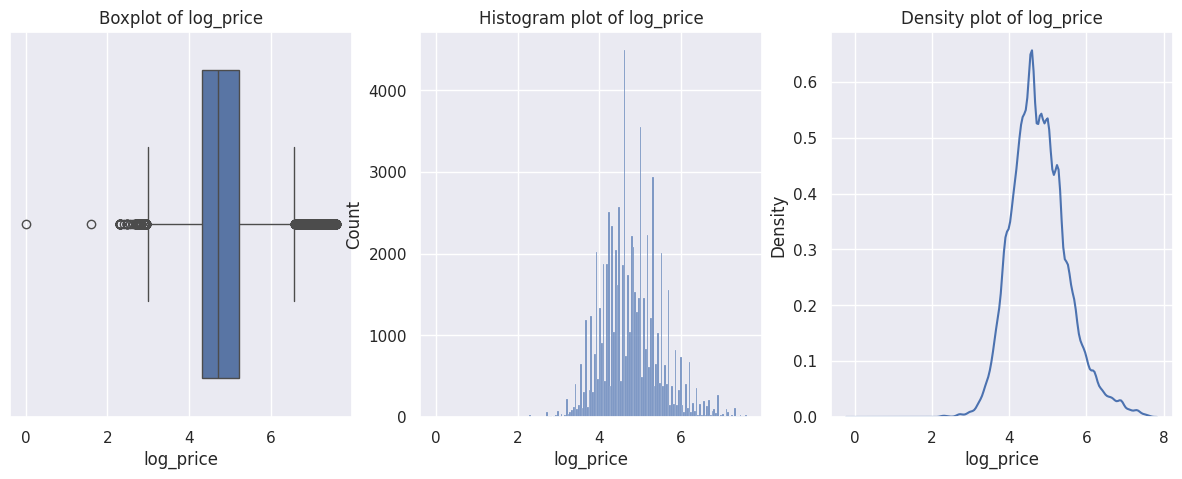

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 1372 and the average of these outliers are: 6.93
*There are no major outliers beyond Quartile-3 + 3*IQR!
*The number of minor outliers below Quartile-1 - 1.5*IQR are: 159 and the average of these outliers are: 2.68
*The number major outliers below Quartile-1 - 3*IQR are: 1 and the average of these outliers are: 0.0
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 4.32
*Quartile-2 (median) is: 4.71
*Quartile-3 is: 5.22
*Quartile-1 - 1.5*IQR =  2.96
*Quartile-1 - 3*IQR =  1.61
*Quartile-3 + 1.5*IQR =  6.57
*Quartile-3 + 3*IQR =  7.93
--------------------------------------------------
--------------------------------------------------
*Average of log_price is: 4.78
*Standard deviation of log_price is: 0.72
*Skewness of log_price is: 0.51
*Kurtosis of log_price is: 0.66
*Coefficient of variation of log_price is: 0.15
*Signal to Noise Ratio of log_price is: 6.6

In [19]:
#Batch univariate analysis of quantitative variables
for i in numeric_col:
  univariate_analysis(data = data, feature = i)

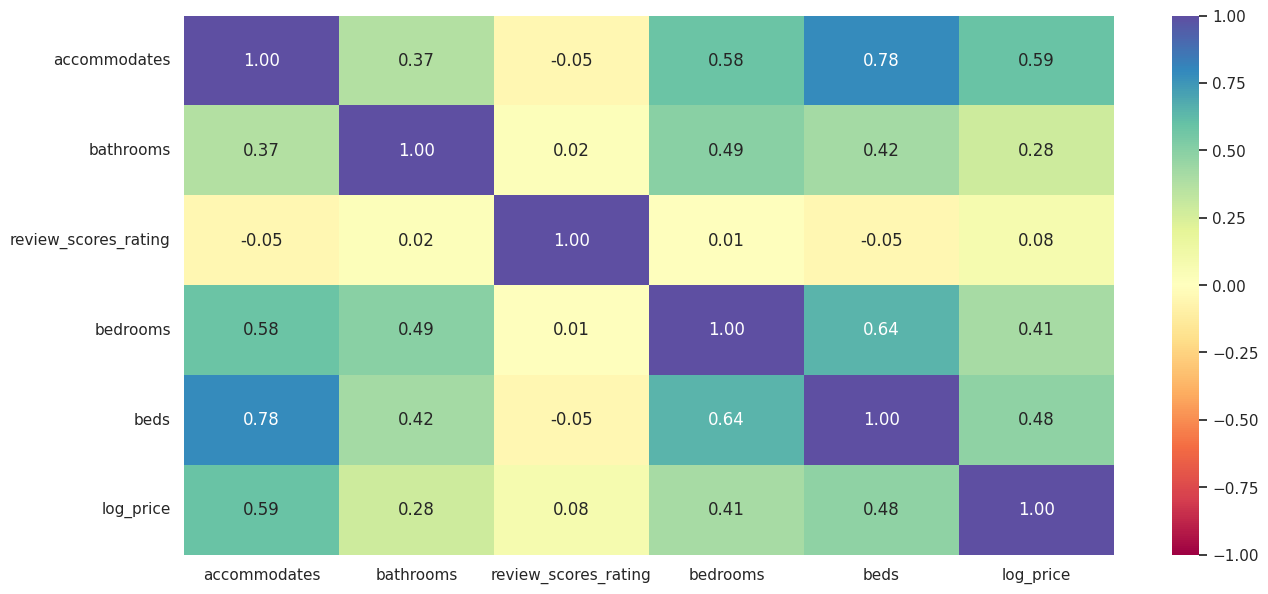

In [20]:
plt.figure(figsize = (15,7))
sns.heatmap(data[numeric_col].corr(method = 'spearman'), annot = True, vmin = -1, vmax = 1, fmt = ".2f", cmap = "Spectral")
plt.show()

###From the above correlation plot, we use rule of thumb rules (MM Mukaka) for determining strength of correlation. We are intersted in predicting prices, so we see that the variable "accommodates" has a moderate positive linear correlation with "log_price," while "bedrooms" and "beds" have a low positive linear wiht "log_price." All other correlations have negligible correlation with "log_price" except for the correlation of "log_price" with itself.

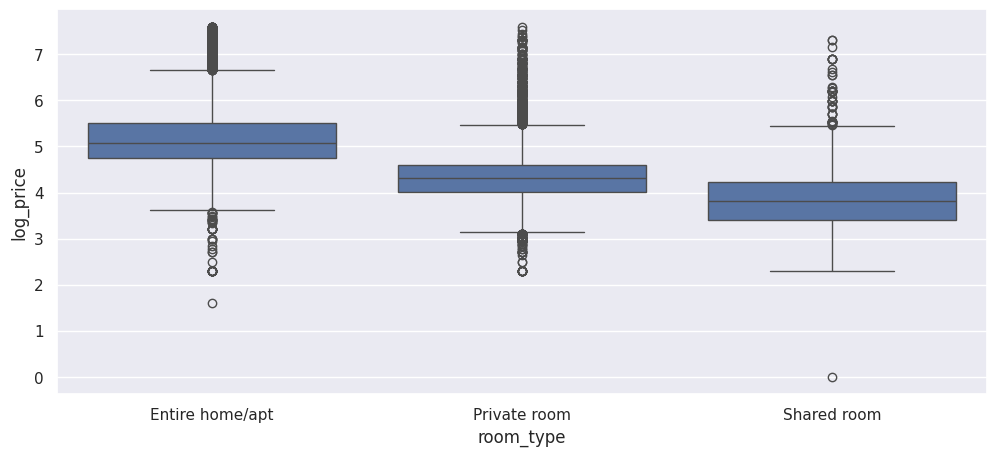

In [21]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="room_type", y="log_price", data=data)
plt.show()

###Pricing decreases as usage space decreases

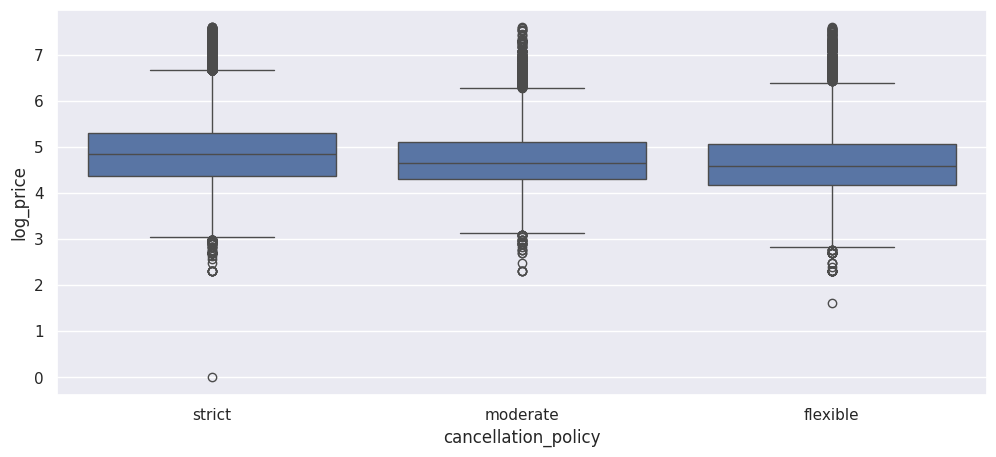

In [22]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="cancellation_policy", y="log_price", data=data)
plt.show()

###Pricing does not substantially vary as a function of cancellation policy

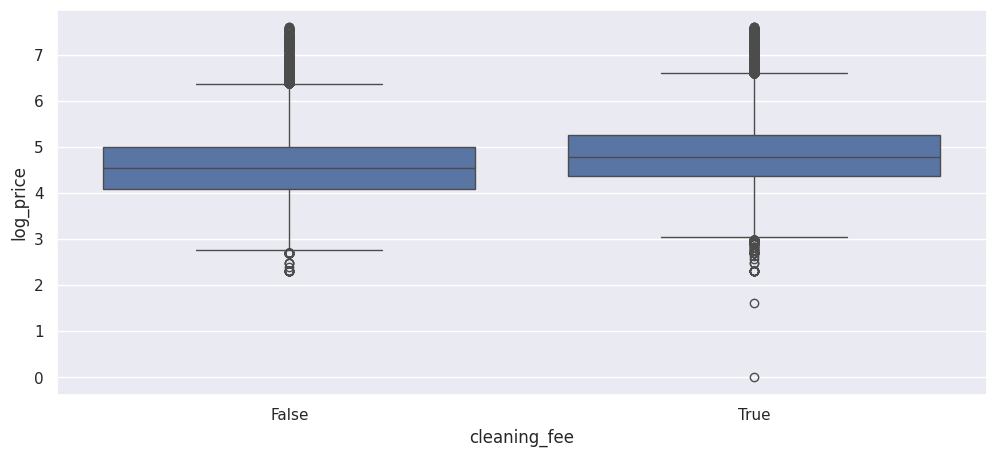

In [23]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="cleaning_fee", y="log_price", data=data)
plt.show()

###A guest should expect to pay slightly more, as one would expect, with a cleaning fee involved

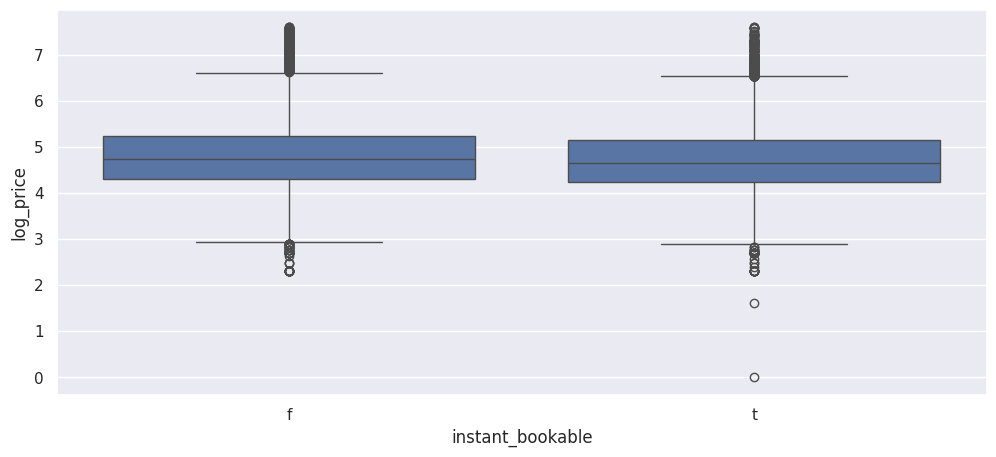

In [24]:
plt.figure(figsize=(12, 5))
sns.boxplot(x="instant_bookable", y="log_price", data=data)
plt.show()

###No substantial price variation as a function of whether the room is instantly bookable or not.

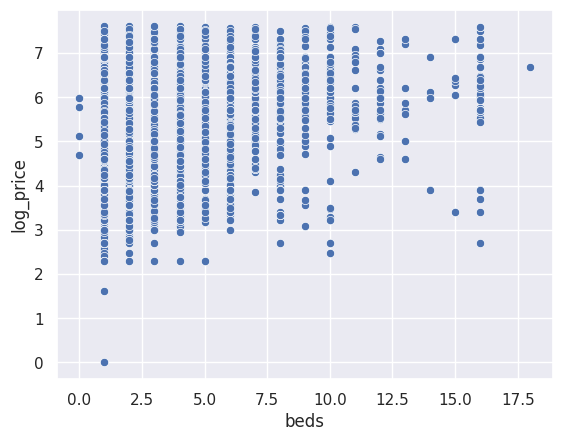

In [25]:
sns.scatterplot(data = data, x = 'beds', y = 'log_price') ; plt.show()

###Missing Value Treatment

In [26]:
data.isnull().sum()

room_type                   5
accommodates                3
bathrooms                 203
cancellation_policy         8
cleaning_fee                4
instant_bookable            0
review_scores_rating    16722
bedrooms                   92
beds                      131
log_price                   0
dtype: int64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   room_type             74106 non-null  object 
 1   accommodates          74108 non-null  float64
 2   bathrooms             73908 non-null  float64
 3   cancellation_policy   74103 non-null  object 
 4   cleaning_fee          74107 non-null  object 
 5   instant_bookable      74111 non-null  object 
 6   review_scores_rating  57389 non-null  float64
 7   bedrooms              74019 non-null  float64
 8   beds                  73980 non-null  float64
 9   log_price             74111 non-null  float64
dtypes: float64(6), object(4)
memory usage: 5.7+ MB


In [28]:
#Impute categorical variables which are missing with the corresponding mode
data.fillna(data.select_dtypes(include = 'object').mode().iloc[0], inplace = True)

In [29]:
#Impute missing quantitative variables with corresponding median based upon other feature variables
cols_list = ['accommodates', 'bathrooms', 'review_scores_rating', 'bedrooms', 'beds']
for col in cols_list:
  data[col] = data.groupby(['room_type', 'cancellation_policy', 'cleaning_fee', 'instant_bookable'])[col].transform(lambda x: x.fillna(x.median()))

data.isnull().sum() #check missing value distribution




room_type               0
accommodates            0
bathrooms               0
cancellation_policy     0
cleaning_fee            0
instant_bookable        0
review_scores_rating    0
bedrooms                0
beds                    0
log_price               0
dtype: int64

In [30]:
#Create Dummy variables for the model
data = pd.get_dummies(data, columns = ['room_type', 'cancellation_policy', 'instant_bookable', 'cleaning_fee'])

In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
accommodates,74111.0,3.155119,2.153566,1.0,2.000000,2.00000,4.000000,16.000000
bathrooms,74111.0,1.234628,0.581386,0.0,1.000000,1.00000,1.000000,8.000000
review_scores_rating,74111.0,94.707466,7.024178,20.0,93.000000,96.00000,99.000000,100.000000
bedrooms,74111.0,1.265467,0.851671,0.0,1.000000,1.00000,1.000000,10.000000
beds,74111.0,1.709773,1.253361,0.0,1.000000,1.00000,2.000000,18.000000
log_price,74111.0,4.782069,0.717394,0.0,4.317488,4.70953,5.220356,7.600402


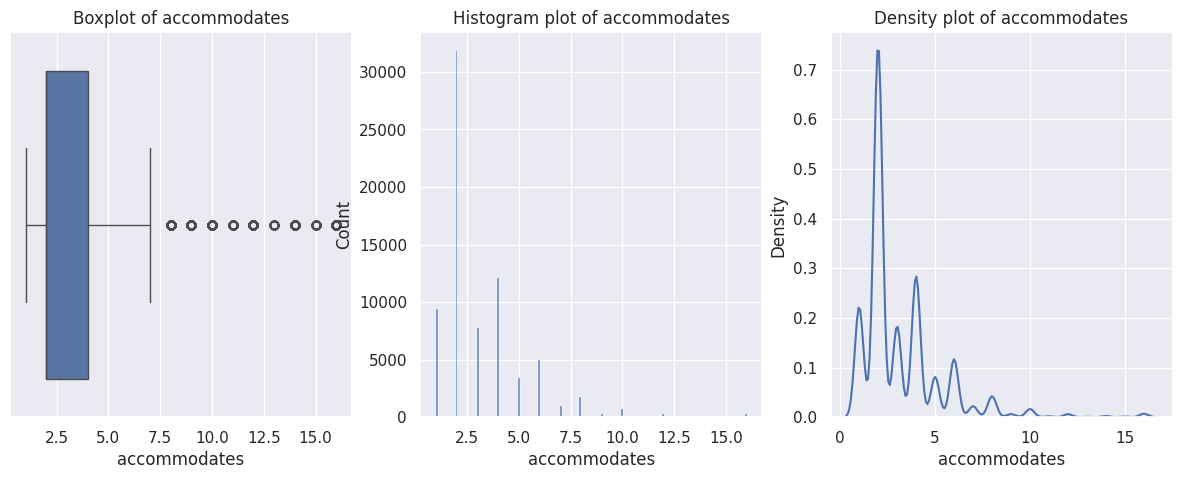

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 2766 and the average of these outliers are: 8.6
*The number major outliers beyond Quartile-3 + 3*IQR are: 838 and the average of these outliers are: 13.83
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 2.0
*Quartile-2 (median) is: 2.0
*Quartile-3 is: 4.0
*Quartile-1 - 1.5*IQR =  -1.0
*Quartile-1 - 3*IQR =  -4.0
*Quartile-3 + 1.5*IQR =  7.0
*Quartile-3 + 3*IQR =  10.0
--------------------------------------------------
--------------------------------------------------
*Average of accommodates is: 3.16
*Standard deviation of accommodates is: 2.15
*Skewness of accommodates is: 2.23
*Kurtosis of accommodates is: 7.43
*Coefficient of variation of accommodates is: 0.68
*Signal to Noise Ratio of accommodates is: 1.47
**Note: Signal to Noise Ratio stat

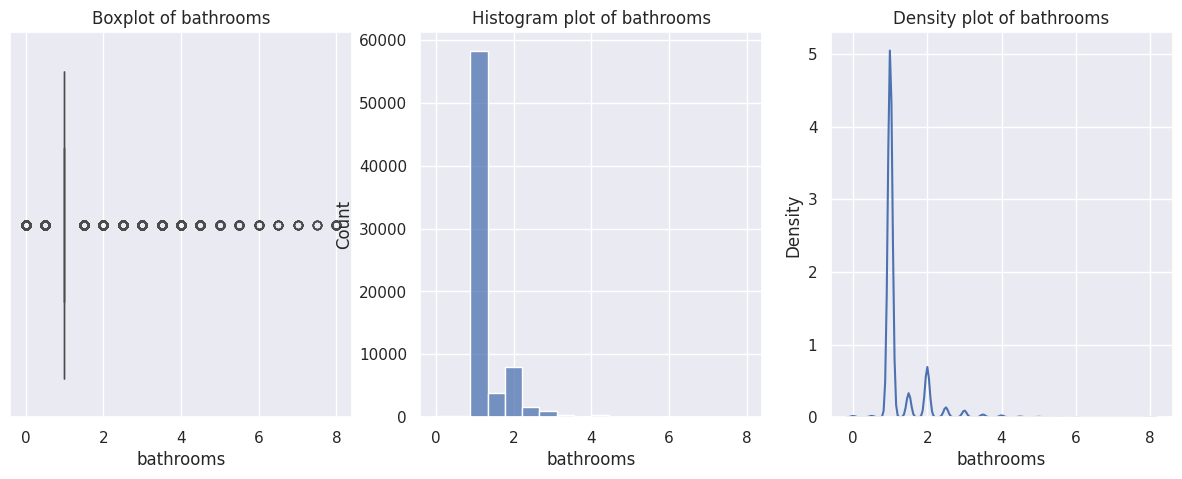

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*The number major outliers beyond Quartile-3 + 3*IQR are: 15405 and the average of these outliers are: 2.15
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*The number major outliers below Quartile-1 - 3*IQR are: 407 and the average of these outliers are: 0.26
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 1.0
*Quartile-1 - 1.5*IQR =  1.0
*Quartile-1 - 3*IQR =  1.0
*Quartile-3 + 1.5*IQR =  1.0
*Quartile-3 + 3*IQR =  1.0
--------------------------------------------------
--------------------------------------------------
*Average of bathrooms is: 1.23
*Standard deviation of bathrooms is: 0.58
*Skewness of bathrooms is: 3.7
*Kurtosis of bathrooms is: 22.3
*Coefficient of variation of bathrooms is: 0.47
*Signal to Noise Ratio of bathrooms is: 2.12
**Note: Signal to Noise Ratio statistic is only applicable

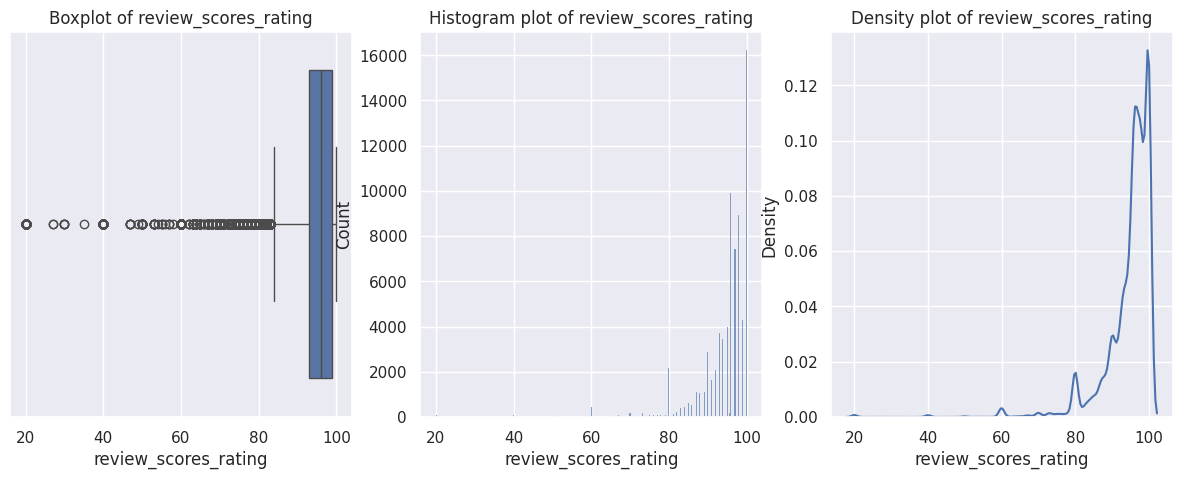

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*There are no major outliers beyond Quartile-3 + 3*IQR!
*The number of minor outliers below Quartile-1 - 1.5*IQR are: 3331 and the average of these outliers are: 80.14
*The number major outliers below Quartile-1 - 3*IQR are: 1291 and the average of these outliers are: 59.81
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 93.0
*Quartile-2 (median) is: 96.0
*Quartile-3 is: 99.0
*Quartile-1 - 1.5*IQR =  84.0
*Quartile-1 - 3*IQR =  75.0
*Quartile-3 + 1.5*IQR =  108.0
*Quartile-3 + 3*IQR =  117.0
--------------------------------------------------
--------------------------------------------------
*Average of review_scores_rating is: 94.71
*Standard deviation of review_scores_rating is: 7.02
*Skewness of review_scores_rating is: -3.89
*Kurtosis of review_scores_rating is: 26.0
*Coefficient of variation of review_scores_rating is: 0.07
*Signal to Noise Ratio of revie

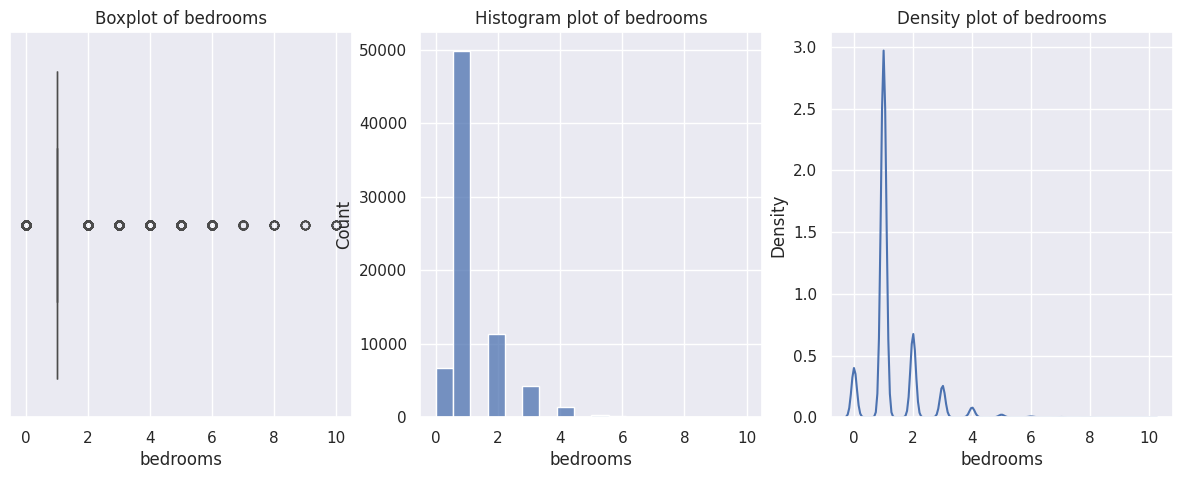

*There are no minor outliers beyond Quartile-3 + 1.5*IQR!
*The number major outliers beyond Quartile-3 + 3*IQR are: 17521 and the average of these outliers are: 2.51
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*The number major outliers below Quartile-1 - 3*IQR are: 6715 and the average of these outliers are: 0.0
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 1.0
*Quartile-1 - 1.5*IQR =  1.0
*Quartile-1 - 3*IQR =  1.0
*Quartile-3 + 1.5*IQR =  1.0
*Quartile-3 + 3*IQR =  1.0
--------------------------------------------------
--------------------------------------------------
*Average of bedrooms is: 1.27
*Standard deviation of bedrooms is: 0.85
*Skewness of bedrooms is: 1.99
*Kurtosis of bedrooms is: 7.6
*Coefficient of variation of bedrooms is: 0.67
*Signal to Noise Ratio of bedrooms is: 1.49
**Note: Signal to Noise Ratio statistic is only applicable to va

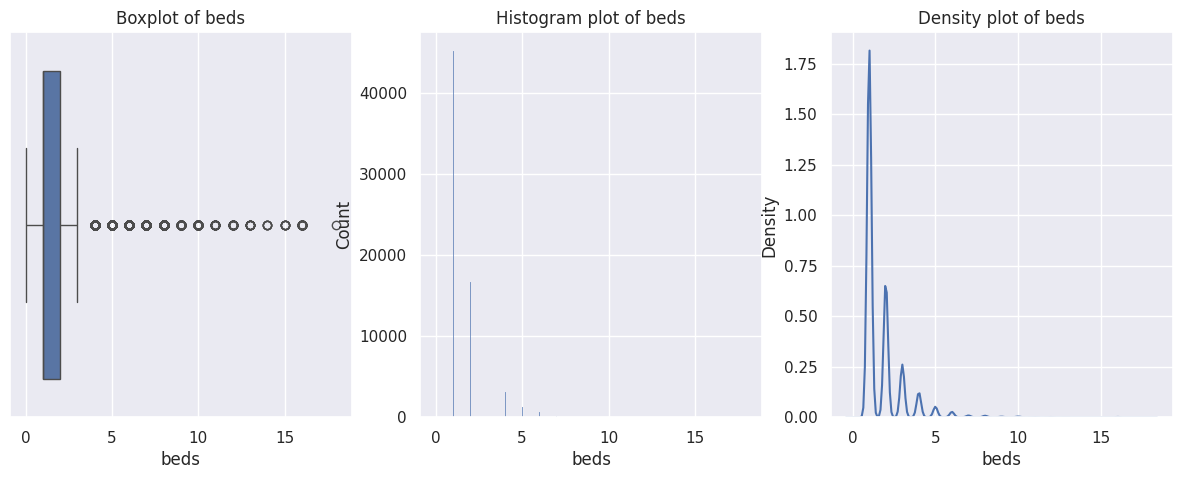

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 4352 and the average of these outliers are: 4.3
*The number major outliers beyond Quartile-3 + 3*IQR are: 1334 and the average of these outliers are: 7.49
*There are no minor outliers below Quartile-1 - 1.5*IQR!
*There are no major outliers below Quartile-1 - 3*IQR!
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 1.0
*Quartile-2 (median) is: 1.0
*Quartile-3 is: 2.0
*Quartile-1 - 1.5*IQR =  -0.5
*Quartile-1 - 3*IQR =  -2.0
*Quartile-3 + 1.5*IQR =  3.5
*Quartile-3 + 3*IQR =  5.0
--------------------------------------------------
--------------------------------------------------
*Average of beds is: 1.71
*Standard deviation of beds is: 1.25
*Skewness of beds is: 3.36
*Kurtosis of beds is: 19.75
*Coefficient of variation of beds is: 0.73
*Signal to Noise Ratio of beds is: 1.36
**Note: Signal to Noise Ratio statistic is only applicable to variables which are 

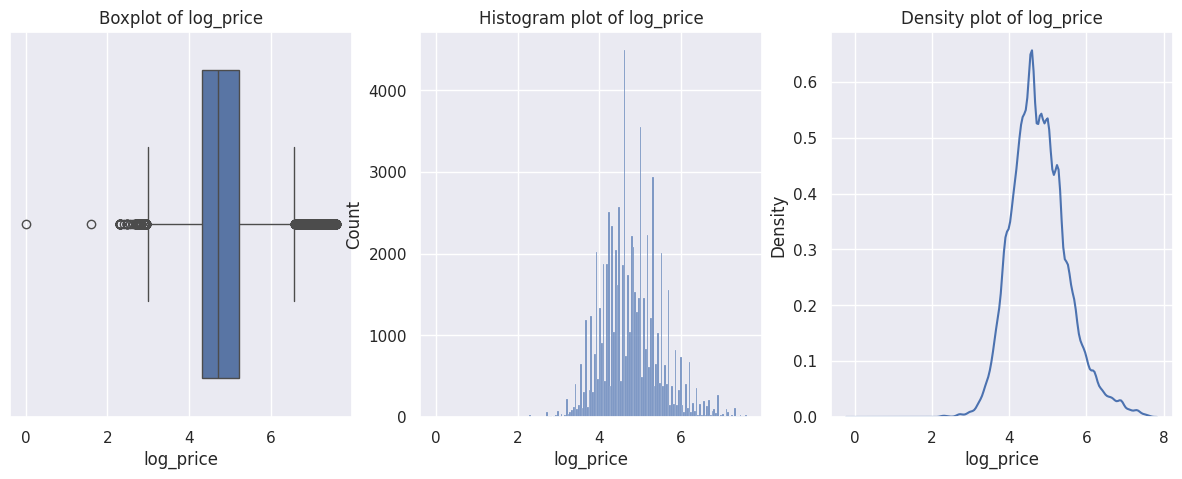

*The number of minor outliers beyond Quartile-3 + 1.5*IQR are: 1372 and the average of these outliers are: 6.93
*There are no major outliers beyond Quartile-3 + 3*IQR!
*The number of minor outliers below Quartile-1 - 1.5*IQR are: 159 and the average of these outliers are: 2.68
*The number major outliers below Quartile-1 - 3*IQR are: 1 and the average of these outliers are: 0.0
--------------------------------------------------
--------------------------------------------------
*Quartile-1 is: 4.32
*Quartile-2 (median) is: 4.71
*Quartile-3 is: 5.22
*Quartile-1 - 1.5*IQR =  2.96
*Quartile-1 - 3*IQR =  1.61
*Quartile-3 + 1.5*IQR =  6.57
*Quartile-3 + 3*IQR =  7.93
--------------------------------------------------
--------------------------------------------------
*Average of log_price is: 4.78
*Standard deviation of log_price is: 0.72
*Skewness of log_price is: 0.51
*Kurtosis of log_price is: 0.66
*Coefficient of variation of log_price is: 0.15
*Signal to Noise Ratio of log_price is: 6.6

In [32]:
#Batch univariate analysis on complete dataset
for i in numeric_col:
  univariate_analysis(data = data, feature = i)

###All missing values are dealt with and the distributions of variables are generally not effected in terms of measures of central tendencies and spread.

##Bivariate Plots

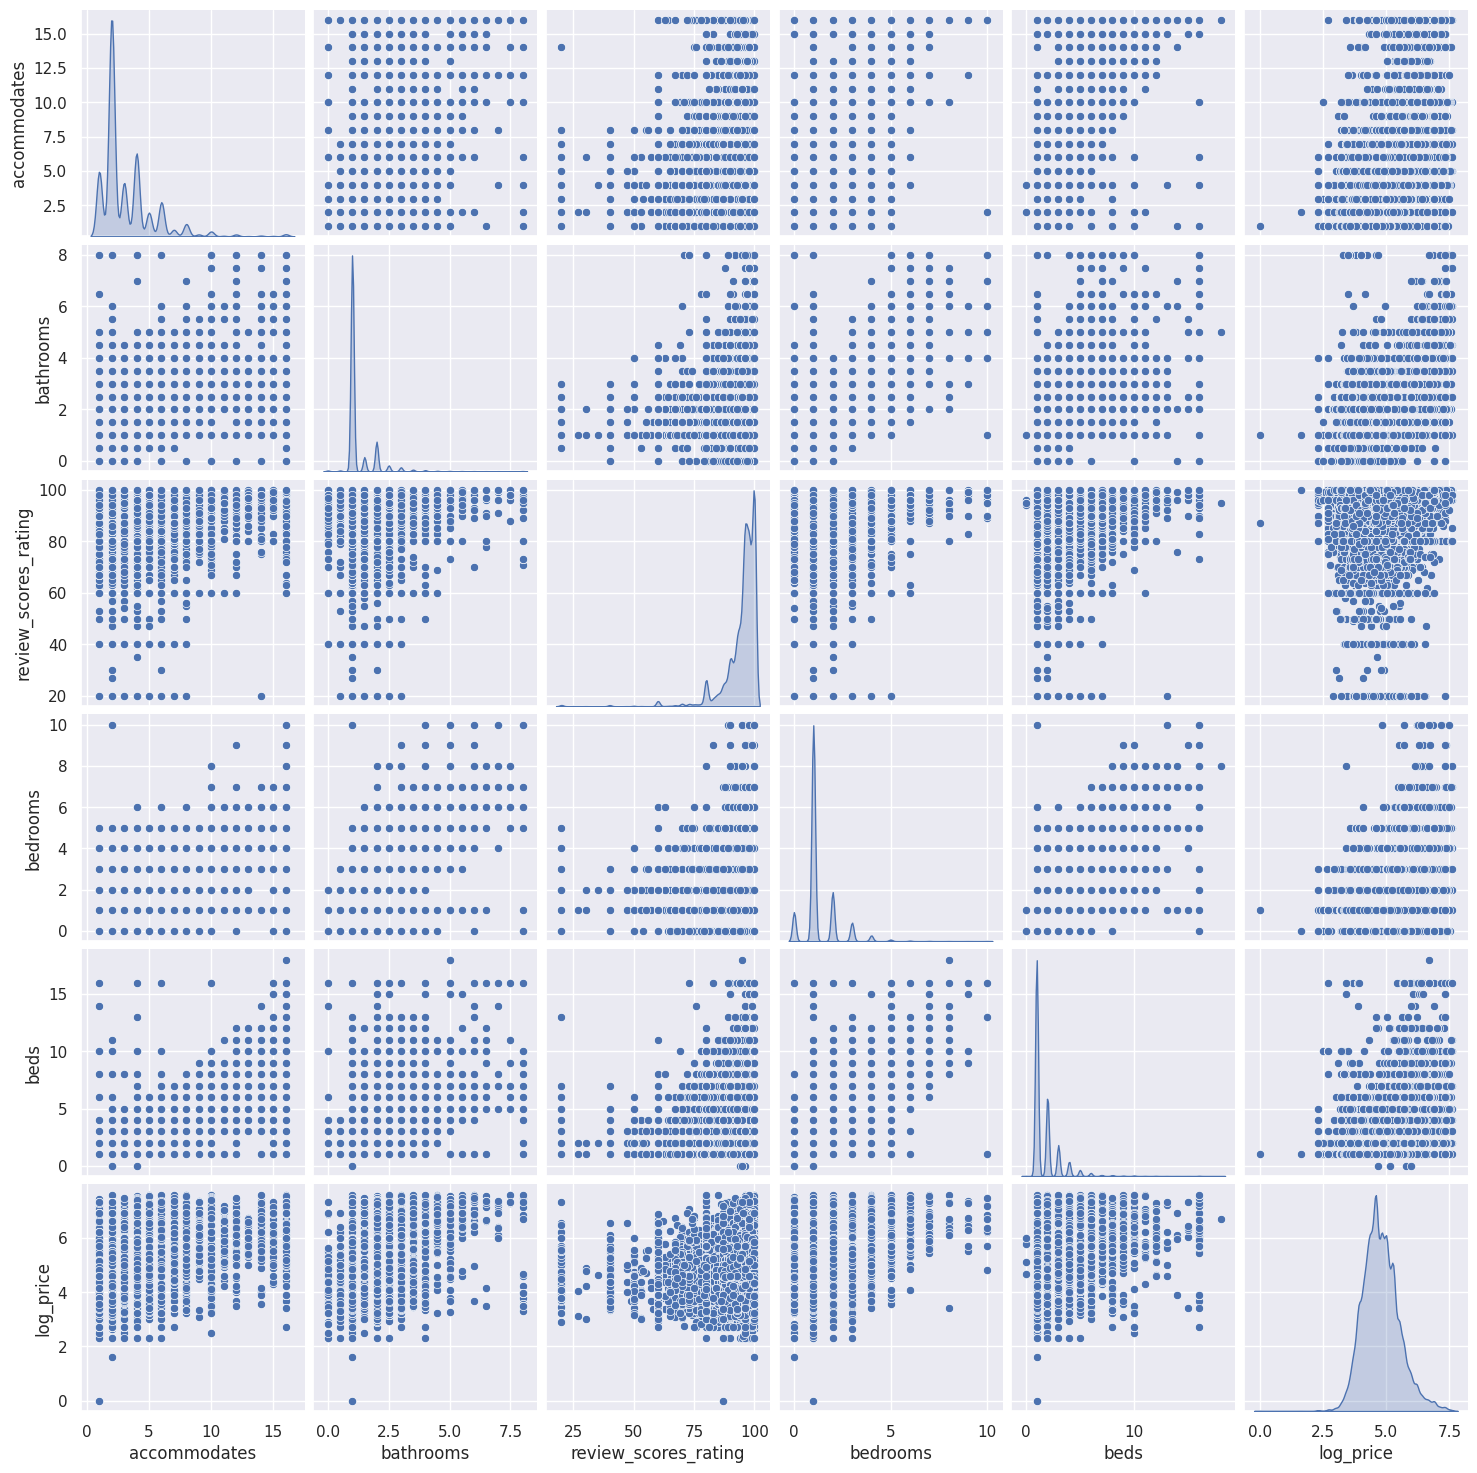

In [33]:
sns.pairplot(data[numeric_col], diag_kind = 'kde')

###From the above pairplot, we see many bivariate scatterplots but associations may be difficult to draw from these plots given the quantitative discrete nature of most of the numeric variables. If we focus on the last row, we can see all associations with our target variable, "log_price," it can be generally concluded that as the number of bathrooms, bedrooms and beds increase, so too does the log_price. However, the relationship of "log_price" to "accommodates" along with the relation of "log_price" to "review_scores_rating" is not clear from the pairplot. From the analysis above of the heatmap, we concluded that the relationship between "accommodates" and "log_price" had a moderately positive linear correlation. The relationship between "review_scores_rating" and "log_price" was of negligible linear correlation.

In [34]:
data.head()

,accommodates,bathrooms,review_scores_rating,bedrooms,beds,log_price,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,instant_bookable_f,instant_bookable_t,cleaning_fee_False,cleaning_fee_True
0,3.0,1.0,100.0,1.0,1.0,5.010635,True,False,False,False,False,True,True,False,False,True
1,7.0,1.0,93.0,3.0,3.0,5.129899,True,False,False,False,False,True,False,True,False,True
2,5.0,1.0,92.0,1.0,3.0,4.976734,True,False,False,False,True,False,False,True,False,True
3,4.0,1.0,98.0,2.0,2.0,6.620073,True,False,False,True,False,False,True,False,False,True
4,2.0,1.0,40.0,0.0,1.0,4.744932,True,False,False,False,True,False,False,True,False,True


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  74111 non-null  float64
 1   bathrooms                     74111 non-null  float64
 2   review_scores_rating          74111 non-null  float64
 3   bedrooms                      74111 non-null  float64
 4   beds                          74111 non-null  float64
 5   log_price                     74111 non-null  float64
 6   room_type_Entire home/apt     74111 non-null  bool   
 7   room_type_Private room        74111 non-null  bool   
 8   room_type_Shared room         74111 non-null  bool   
 9   cancellation_policy_flexible  74111 non-null  bool   
 10  cancellation_policy_moderate  74111 non-null  bool   
 11  cancellation_policy_strict    74111 non-null  bool   
 12  instant_bookable_f            74111 non-null  bool   
 13  i

#Model Building Linear Regression




###Split Data

In [36]:
# lets build the linear model
#independent variables
X = data.drop(['log_price', 'room_type_Entire home/apt', 'cancellation_policy_flexible', 'instant_bookable_f', 'cleaning_fee_False' ], axis = 1)
#the dependant variable
y = data[['log_price']]

In [37]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

##Fit Linear Model

In [38]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

#####Here are the coefficients for each variable and the intercept

In [39]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for accommodates is 0.0794754900849728
The coefficient for bathrooms is 0.1476867795470543
The coefficient for review_scores_rating is 0.007829745267961742
The coefficient for bedrooms is 0.1507345904288996
The coefficient for beds is -0.05071405303825113
The coefficient for room_type_Private room is -0.6393736603672845
The coefficient for room_type_Shared room is -1.1083615134537532
The coefficient for cancellation_policy_moderate is -0.04947051664704516
The coefficient for cancellation_policy_strict is 0.00020480487320564608
The coefficient for instant_bookable_t is -0.05088095894421832
The coefficient for cleaning_fee_True is -0.06859763401827808


In [40]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 3.8749333624809843


#####The score R**2 for in-sample and out of sample

In [41]:
regression_model.score(X_train, y_train)

0.5204519374595734

In [42]:
#out of sample score R**2
regression_model.score(X_test, y_test)

0.5177658355757446

###Adding interaction terms

In [43]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

poly_clf = linear_model.LinearRegression()

poly_clf.fit(X_train2, y_train)

y_pred = poly_clf.predict(X_test2)

#print(y_pred)

#In sample (training) R**2 ALWAYS the number of variables!
print(poly_clf.score(X_train2, y_train))

0.5410220905626271


In [59]:
#Out off sample (testing) R**2 is our measure of success and does improve at the expense of more variable addition which is acceptable in predictive analytics
print(poly_clf.score(X_test2, y_test))

0.5381464822201947


##Business Insights following analysis

From the enhanced model with interaction terms, we see a coefficient of determination of approximately 0.54 meaning of the variables available and included in the enhanced model, those variables are able to explain approximately 54% of the variance in our target variable, price. Our goal is to be able to predict price based on salient features. Such a coefficient of determiniation should be deemed as relatively unnacceptable for predictive purposes which should trigger a search for better data to increase this metric. The model should and can be used as a test for other models to determine if their could be better model improvement with a different set of variables and or different model. The relationship in which we are trying to predict may not be inherently linear and nonlinear models should be explored.  